# 基本面选股

In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

# 回测框架
import backtrader as bt
import backtrader.indicators as btind

# 基础函数
import utilsJ

## 基本面因子

### 盈利性
+ 毛利率 - netprofit_margin
+ 净利率 - grossprofit_margin
+ 扣非净资产收益率 - roe_dt
+ 营收同比增长率 - or_yoy
+ 净利润同比增长率 - dt_netprofit_yoy (归母扣非净利润同比增长率)
+ 扣非净利润 - dtprofit_to_profit

### 流动性
+ 资产负债率 - debt_to_assets
+ 流动比率 - current_ratio
+ 速动比率 - quick_ratio
+ 应收账款周转率 - ar_turn
+ 应收账款账龄分布
+ 存货周转率 - inv_turn

### 估值
+ PE倍数（市盈率）- pe
+ PB倍数（市净率）- pb
+ PEG

### 其他
+ 商誉占总资产比重 goodwill / total_assets
+ 商誉占净资产比重 goodwill / (total_assets - total_liab)

In [2]:
def fund_ind(token, stock_code,
             start=dt.datetime.now()-dt.timedelta(days=365),
             end=dt.datetime.now()):
    ts.set_token(token)
    pro = ts.pro_api()

    ### Finance Indicators
    find_fields = ['netprofit_margin', 'grossprofit_margin', 'roe_dt', 'or_yoy', 'dt_netprofit_yoy', 'dtprofit_to_profit',
                   'debt_to_assets', 'current_ratio', 'quick_ratio', 'ar_turn', 'inv_turn']
    df_find = pro.fina_indicator(ts_code=stock_code, 
                                 start_date=start.strftime('%Y%m%d'),
                                 end_date=end.strftime('%Y%m%d'))
    non_index_list = [x for x in find_fields if x not in df_find.columns]
    df_find = df_find[['end_date'] + [x for x in find_fields if x in df_find.columns]].drop_duplicates()
    for non_index in non_index_list:
        df_find[non_index] = 0
    df_find.rename(columns = {'end_date':'trade_date'}, inplace = True)
    

    ### Balance Sheets
    df_bs = pro.balancesheet(ts_code=stock_code, 
                         start_date=start.strftime('%Y%m%d'),
                         end_date=end.strftime('%Y%m%d'), 
                         fields='end_date, goodwill, total_assets, total_liab')
    df_bs['goodwill'] = df_bs['goodwill'].fillna(0)
    df_bs['gw/a'] = df_bs.goodwill / df_bs.total_assets
    df_bs['gw/n'] = df_bs.goodwill / (df_bs.total_assets - df_bs.total_liab)
    df_bs.drop(columns=['goodwill', 'total_assets', 'total_liab'], inplace=True)
    df_bs.rename(columns={'end_date':'trade_date'}, inplace=True)

    ### Daliy
    df_daily = pro.daily_basic(ts_code=stock_code, 
                           start_date=start.strftime('%Y%m%d'),
                           end_date=end.strftime('%Y%m%d'), 
                           fields='trade_date, pe, pb')[::-1]
    df_daily['pe'] = df_daily['pe'].fillna(0)

    df_final = df_daily.merge(df_find, on='trade_date', how='left').merge(df_bs, on='trade_date', how='left')
    df_final['trade_date'] = pd.to_datetime(df_final.trade_date)
    df_final.index=pd.to_datetime(df_final.trade_date)
    df_final.drop('trade_date', axis=1, inplace = True)
    df_final.fillna(method='bfill', inplace=True)
    df_final.fillna(method='pad', inplace=True)
    return df_final

# 全市场循环测试

In [3]:
condition = {
    'netprofit_margin' : (1, 30),
    'grossprofit_margin' : (1, 20),
    'roe_dt' : (1, 15),
    'or_yoy' : (1, 15),
    'dt_netprofit_yoy' : (1, 15),
    'debt_to_assets' : (-1, 50),
    'current_ratio' : (1, 2),
    'quick_ratio' : (1, 2),
    'pe' : (1, 30),
    'pb' : (1, 1)
}

In [4]:
s_date = dt.datetime.now() - dt.timedelta(days = 365)
e_date = dt.datetime.now()

stock_list = utilsJ.get_stock_list()

comp_per = {}
for s_code in stock_list:
    try:
        comp_per[s_code] = 0
        df = fund_ind(token, s_code, s_date, e_date)
        if len(df) != 0:
            for col in df.columns:
                if col in condition.keys() and df.loc[:, col][-1] != 0:
                    if condition[col][0] == 1:
                        comp_per[s_code] += 1 if df.loc[:, col][-1] >= condition[col][1] else 0
                    else:
                        comp_per[s_code] += 1 if df.loc[:, col][-1] <= condition[col][1] else 0
            print((s_code, comp_per[s_code]))
            time.sleep(4)
    except:
        print(s_code)

In [8]:
sorted(comp_per.items(), key=lambda x:x[1], reverse=True)

[('000661.SZ', 10),
 ('002007.SZ', 10),
 ('002214.SZ', 10),
 ('002901.SZ', 10),
 ('002932.SZ', 10),
 ('002978.SZ', 10),
 ('002980.SZ', 10),
 ('002985.SZ', 10),
 ('003026.SZ', 10),
 ('300394.SZ', 10),
 ('300443.SZ', 10),
 ('300529.SZ', 10),
 ('300595.SZ', 10),
 ('300677.SZ', 10),
 ('300699.SZ', 10),
 ('300701.SZ', 10),
 ('300726.SZ', 10),
 ('300760.SZ', 10),
 ('300770.SZ', 10),
 ('300776.SZ', 10),
 ('300777.SZ', 10),
 ('300782.SZ', 10),
 ('300832.SZ', 10),
 ('300841.SZ', 10),
 ('300888.SZ', 10),
 ('300896.SZ', 10),
 ('603258.SH', 10),
 ('603444.SH', 10),
 ('603666.SH', 10),
 ('000416.SZ', 9),
 ('002022.SZ', 9),
 ('002027.SZ', 9),
 ('002030.SZ', 9),
 ('002414.SZ', 9),
 ('002507.SZ', 9),
 ('002568.SZ', 9),
 ('002833.SZ', 9),
 ('002838.SZ', 9),
 ('002859.SZ', 9),
 ('002919.SZ', 9),
 ('002975.SZ', 9),
 ('002979.SZ', 9),
 ('002987.SZ', 9),
 ('003028.SZ', 9),
 ('300142.SZ', 9),
 ('300151.SZ', 9),
 ('300206.SZ', 9),
 ('300379.SZ', 9),
 ('300408.SZ', 9),
 ('300474.SZ', 9),
 ('300481.SZ', 9),
 (

# 机器学习

In [53]:
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(20, 10))
model.add(Activation('relu'))
model.add(Dense(10, 4))
model.add(Activation('relu'))
model.add(Dense(4, 1))

model.compile(loss='mean_squared_error', optimizer='adam', class_mode=None)

ModuleNotFoundError: No module named 'tensorflow'

d:\Anaconda\envs\py38\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

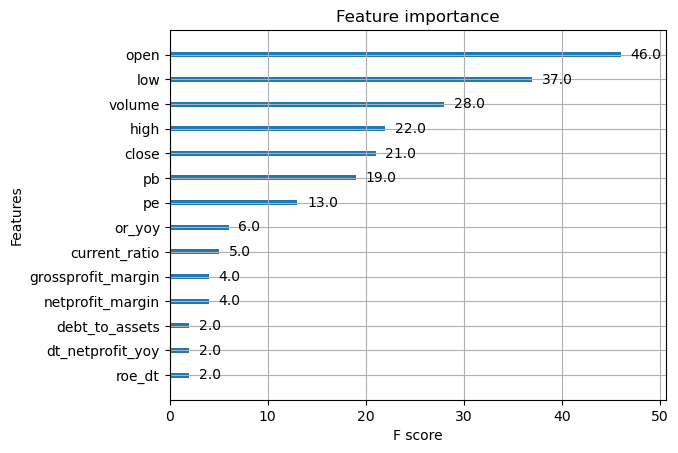

In [48]:
s_date = datetime.datetime.now() - datetime.timedelta(days=365*3)
e_date = datetime.datetime.now() - datetime.timedelta(days=365)
s_code = '002057.SZ'
token = '74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6'
df1 = fund_ind(token, s_code, s_date, e_date)
df2 = utilsJ.stock_tushare(token, s_code, s_date, e_date)
df = df1.merge(df2, on='trade_date')
df['return'] = df.close / df.close.shift(1) - 1
df.drop(index=df.index[0], inplace=True)


In [49]:
s_date = datetime.datetime.now() - datetime.timedelta(days=365)
e_date = datetime.datetime.now()
s_code = '002057.SZ'
token = '74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6'
df1 = fund_ind(token, s_code, s_date, e_date)
df2 = utilsJ.stock_tushare(token, s_code, s_date, e_date)
df = df1.merge(df2, on='trade_date')
df['return'] = df.close / df.close.shift(1) - 1
df.drop(index=df.index[0], inplace=True)

#test = xgb.DMatrix(df[df.columns[:20]])
#model.predict(test)

d:\Anaconda\envs\py38\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([0.489898  , 0.49032742, 0.489898  , 0.5062012 , 0.49032742,
       0.5308869 , 0.52560693, 0.54031456, 0.5236996 , 0.49984646,
       0.51477563, 0.5237907 , 0.521847  , 0.52632225, 0.52453434,
       0.51600444, 0.50872254, 0.50872254, 0.5014233 , 0.51336473,
       0.48431432, 0.48616987, 0.49308765, 0.5106498 , 0.49782175,
       0.48712862, 0.48616987, 0.49101695, 0.51103216, 0.4946959 ,
       0.47988263, 0.4775125 , 0.47778252, 0.48703706, 0.4980901 ,
       0.5184707 , 0.49319252, 0.5008877 , 0.49319252, 0.5168262 ,
       0.5128905 , 0.5043397 , 0.49904597, 0.48363304, 0.5033809 ,
       0.50000477, 0.50000477, 0.50135714, 0.48964116, 0.48964116,
       0.48866725, 0.48866725, 0.48963127, 0.48963127, 0.47725546,
       0.48978433, 0.48435205, 0.49515346, 0.49560925, 0.49774012,
       0.4952831 , 0.47988263, 0.49494007, 0.48162827, 0.49560925,
       0.48133856, 0.49213997, 0.5016059 , 0.4982826 , 0.48930916,
       0.50000817, 0.5107314 , 0.50874144, 0.49046966, 0.50031

In [51]:
df['return']

trade_date
2021-10-20   -0.014499
2021-10-21    0.008834
2021-10-22   -0.017498
2021-10-25    0.019285
2021-10-26    0.000000
                ...   
2022-10-12    0.028283
2022-10-13    0.001965
2022-10-14    0.046078
2022-10-17   -0.015933
2022-10-18    0.002857
Name: return, Length: 242, dtype: float64